# Level 1: Local Frog Discovery Tool notebook

## Challenge Level 1 Overview


Welcome to the 2022 EY Data Science Challenge! This is the first challenge aimed at beginner/intermediate participants that have little to no experience in data science and programming. For more experienced participants, we recommend undertaking challenge level 2 outlined [here](Model_Level_2.ipynb). If you choose to undertake the first level of the challenge, you will be developing a species distribution model (SDM) for one Australian frog species using only variables from the TerraClimate dataset. A species distribution model is a specific type of machine learning model that aims to predict the distribution of a biological species across geographic space and time. Such models have become increasingly important in conservation efforts globally to better understand and map the habitats of species of interest, particularly threatened or endangered species. 

The frog species identified for this challenge is Litoria fallax, the eastern dwarf tree frog pictured below. In addition to assisting our understanding of this specific frog species, a successful frog SDM will have broader implications in quantifying biodiversity. This is because frogs are incredibly sensitive to environmental changes, so any changes in their species distribution may indicate an underlying change to biodiversity in the area. 

<center>
<img src="pictures/Litoria_fallax.jpg" width="500" height="340">
</center>

<br>

**Challenge aim:** to develop a species distribution model for litoria fallax across Australia using weather data from the TerraClimate dataset.

| Challenge | Locations                     | Spatial Res        | Species          | Satellite Data                                                |
|-----------|-------------------------------|--------------------|------------------|---------------------------------------------------------------|
|***1***    | Australia                     | Coarse (4km)  | 1 species  | TerraClimate                                                  |
|2     | Australia, Costa Rica,<br>South Africa | Fine (10m)   | 15 species     | TerraClimate, Sentinel-2,<br>Land cover, water extent, elevation |


In [1]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Plotting
import matplotlib.pyplot as plt

# Data science
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer

# Geospatial
import contextily as cx
import xarray as xr
import zarr # Not referenced, but required for xarray

# Import Planetary Computer tools
import fsspec
import pystac

# Other
import os
import zipfile
from itertools import cycle

# Path to data folder with provided material
data_path = '../'

### Response Variable

In [2]:
if not os.path.exists(data_path+'training_data/'):
    os.mkdir(data_path+'training_data/')
    with zipfile.ZipFile(data_path+'GBIF_training_data.zip', 'r') as zip_ref:
        zip_ref.extractall(data_path+'training_data/')
        
def filter_bbox(frogs, bbox):
    frogs = frogs[lambda x: 
        (x.decimalLongitude >= bbox[0]) &
        (x.decimalLatitude >= bbox[1]) &
        (x.decimalLongitude <= bbox[2]) &
        (x.decimalLatitude <= bbox[3])
    ]
    return frogs

def get_frogs(file, year_range=None, bbox=None):
    """Returns the dataframe of all frog occurrences for the bounding box specified."""
    columns = [
        'gbifID','eventDate','country','continent','stateProvince',
        'decimalLatitude','decimalLongitude','species'
    ]
    country_names = {
        'AU':'Australia', 'CR':'Costa Rica', 'ZA':'South Africa','MX':'Mexico','HN':'Honduras',
        'MZ':'Mozambique','BW':'Botswana','MW':'Malawi','CO':'Colombia','PA':'Panama','NI':'Nicaragua',
        'BZ':'Belize','ZW':'Zimbabwe','SZ':'Eswatini','ZM':'Zambia','GT':'Guatemala','LS':'Lesotho',
        'SV':'El Salvador', 'AO':'Angola', np.nan:'unknown or invalid'
    }
    continent_names = {
        'AU':'Australia', 'CR':'Central America', 'ZA':'Africa','MX':'Central America','HN':'Central America',
        'MZ':'Africa','BW':'Africa','MW':'Africa','CO':'Central America','PA':'Central America',
        'NI':'Central America','BZ':'Central America','ZW':'Africa','SZ':'Africa','ZM':'Africa',
        'GT':'Central America','LS':'Africa','SV':'Central America','AO':'Africa', np.nan:'unknown or invalid' 
    }
    frogs = (
        pd.read_csv(data_path+'training_data/occurrence.txt', sep='\t', parse_dates=['eventDate'])
        .assign(
            country =  lambda x: x.countryCode.map(country_names),
            continent =  lambda x: x.countryCode.map(continent_names),
            species = lambda x: x.species.str.title()
        )
        [columns]
    )
    if year_range is not None:
        frogs = frogs[lambda x: 
            (x.eventDate.dt.year >= year_range[0]) & 
            (x.eventDate.dt.year <= year_range[1])
        ]
    if bbox is not None:
        frogs = filter_bbox(frogs, bbox)
    return frogs

### Sub-sampling

In [3]:
#Frog Region 2 - Victoria, NSW, Southern Queenland coastline
region_name = 'South Eastern Coastline'
min_lon, min_lat = (149.618641, -36.867231)  # Lower-left corner
max_lon, max_lat = (152.909790, -25.290807)  # Upper-right corner
bbox = (min_lon, min_lat, max_lon, max_lat)

all_frog_data = get_frogs(data_path+'/training_data/occurrence.txt', year_range=(2018, 2019), bbox=bbox)
all_frog_data

,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species
7,1944370584,2018-04-18 19:05:00,Australia,Australia,New South Wales,-33.693144,151.320884,Litoria Fallax
17,2423011701,2019-08-28 09:24:00,Australia,Australia,New South Wales,-33.925746,151.164082,Litoria Fallax
21,2236299662,2018-02-13 23:02:00,Australia,Australia,New South Wales,-31.732415,152.088515,Litoria Fallax
53,3031765405,2018-02-20 15:20:00,Australia,Australia,Queensland,-27.400618,152.800944,Litoria Fallax
521,2446280067,2018-01-22 00:00:00,Australia,Australia,New South Wales,-33.086880,151.420570,Litoria Fallax
...,...,...,...,...,...,...,...,...
193477,3108845537,2019-10-15 00:00:00,Australia,Australia,New South Wales,-33.718800,150.385000,Crinia Signifera
193482,3108845654,2019-09-21 00:00:00,Australia,Australia,New South Wales,-33.091900,151.465000,Litoria Fallax
193486,3108865868,2019-02-03 00:00:00,Australia,Australia,New South Wales,-34.028797,151.225626,Litoria Fallax
193507,3408189344,2019-12-24 21:22:00,Australia,Australia,Queensland,-26.754987,152.839291,Litoria Fallax


### Adressing Bias

In [4]:
def plot_species(fig, ax, frog_data, region_name, cmap_params={'alpha':0.5}, scatter_params={'alpha':0.5}):
    # Bar chart
    bar_data = frog_data.species.value_counts()
    barchart = ax[1].bar(bar_data.index.str.replace(' ', '\n'), bar_data)

    # Colour cycle to ensure colors match in both plots
    prop_cycle = cycle(plt.rcParams['axes.prop_cycle'])
    for i, color in zip(range(len(bar_data)), prop_cycle):
        species_name = bar_data.index[i]
        if len(species_name) > 19:
            display_name = species_name.replace(' ', '\n')
        else:
            display_name = species_name
        barchart[i].set_color(color['color'])
        barchart[i].set_label(f"{display_name}\nCount: {bar_data[i]}")
        filt = frog_data.species == species_name
        # Scatter plot
        ax[0].scatter(
            frog_data[filt].decimalLongitude, 
            frog_data[filt].decimalLatitude, 
            marker='.', 
            color=color['color'],
            **scatter_params
        )

    # Add other features
    ax[0].set_title(f"Frog occurrences for {region_name}")
    # ax[0].set_xticklabels([])
    # ax[0].set_yticklabels([])
    ax[1].set_title(f"Frog species distribution in {region_name}")
    cx.add_basemap(ax[0], crs={'init':'epsg:4326'}, **cmap_params) # Add basemap
    ax[1].set_xticklabels(bar_data.index.str.replace(' ', '\n'), rotation=45)
    ax[1].legend()
    
    
def plot_barchart(bar_data, ax, bar_params={}, fold_text=True):
    barchart = ax.bar(bar_data.index, bar_data, **bar_params)
    prop_cycle = cycle(plt.rcParams['axes.prop_cycle'])
    for i, color in zip(range(len(bar_data)), prop_cycle):
        var_name = bar_data.index[i]
        barchart[i].set_color(color['color'])
        barchart[i].set_label(f"{var_name}\nCount: {bar_data[i]}")
    ax.set_xticklabels(bar_data.index.str.replace(' ', '\n'), rotation=45)
    ax.legend()

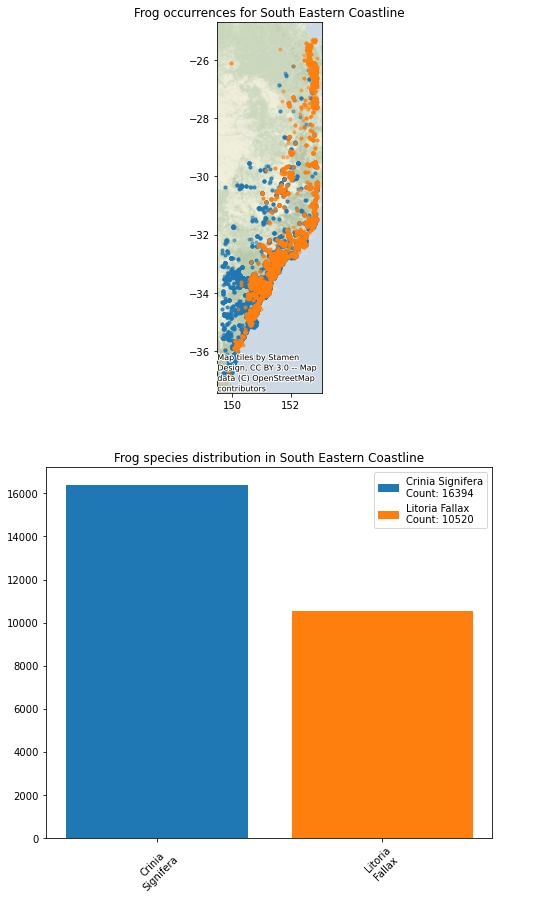

In [5]:
#visualise the frog species distribution of the area. 
#Here, only two of the five Australian species are present: crinia signifera, the common eastern froglet, 
#and litoria fallax, the eastern dwarf tree frog.
fig, ax = plt.subplots(2, 1, figsize=(8, 15))
plot_species(fig, ax, all_frog_data, region_name)

In [6]:
target_species = 'Litoria Fallax'

all_frog_data = (
    all_frog_data
    # Assign the occurrenceStatus to 1 for the target species and 0 for all other species.
    # as well as a key for joining (later)
    .assign(
        occurrenceStatus = lambda x: np.where(x.species == target_species, 1, 0)
        
    )
    .reset_index(drop=True)
    .assign(key=lambda x: x.index)
)
all_frog_data.head()

,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species,occurrenceStatus,key
0,1944370584,2018-04-18 19:05:00,Australia,Australia,New South Wales,-33.693144,151.320884,Litoria Fallax,1,0
1,2423011701,2019-08-28 09:24:00,Australia,Australia,New South Wales,-33.925746,151.164082,Litoria Fallax,1,1
2,2236299662,2018-02-13 23:02:00,Australia,Australia,New South Wales,-31.732415,152.088515,Litoria Fallax,1,2
3,3031765405,2018-02-20 15:20:00,Australia,Australia,Queensland,-27.400618,152.800944,Litoria Fallax,1,3
4,2446280067,2018-01-22 00:00:00,Australia,Australia,New South Wales,-33.086880,151.420570,Litoria Fallax,1,4


### Class Balancing

Text(0.5, 1.0, 'Balanced training set')

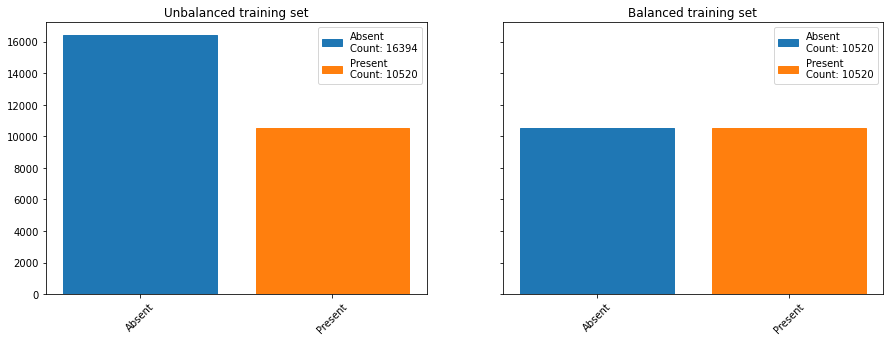

In [7]:
target_species_frog_data = all_frog_data[all_frog_data.occurrenceStatus == 1]
frog_data = (
    all_frog_data
    [lambda x: x.occurrenceStatus == 0]
    .sample(
        len(target_species_frog_data), random_state=420
    )
    .append(target_species_frog_data)
    # assign key for joining purposes
    .reset_index(drop=True)
    .assign(key=lambda x: x.index)
)
# Bar charts
fig, ax = plt.subplots(1, 2, figsize = (15, 5), sharey=True, sharex=True)
bar_data = all_frog_data.occurrenceStatus.map({1:'Present', 0:'Absent'}).value_counts()
plot_barchart(bar_data, ax[0], bar_params={})
ax[0].set_title('Unbalanced training set')
balanced_bar_data = frog_data.occurrenceStatus.map({1:'Present', 0:'Absent'}).value_counts()
plot_barchart(balanced_bar_data, ax[1], bar_params={})
ax[1].set_title('Balanced training set')

Text(0.5, 1.0, 'Training set for South Eastern Coastline')

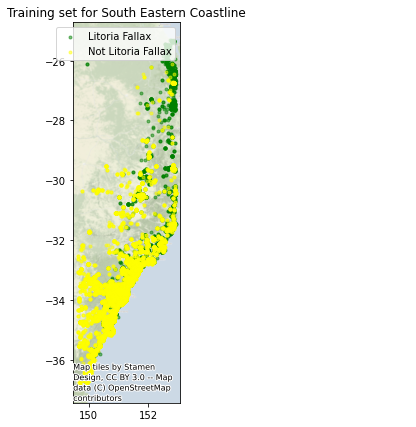

In [8]:
fig, ax = plt.subplots(figsize = (7, 7))

filt = all_frog_data.occurrenceStatus == 1
ax.scatter(all_frog_data[filt].decimalLongitude, all_frog_data[filt].decimalLatitude,
           color = 'green', marker='.', alpha=0.5, label=target_species)
ax.scatter(all_frog_data[~filt].decimalLongitude, all_frog_data[~filt].decimalLatitude,
           color = 'yellow', marker='.', alpha=0.5, label=f"Not {target_species}")
ax.legend()
cx.add_basemap(ax, crs={'init':'epsg:4326'}, alpha=0.5)
ax.set_title(f"Training set for {region_name}")

### Accessing the TerraClimate Data

In [9]:
def get_terraclimate(bbox, metrics, time_slice=None, assets=None, features=None, interp_dims=None, verbose=True):
    """Returns terraclimate metrics for a given area, allowing results to be interpolated onto a larger image.
    
    Attributes:
    bbox -- Tuple of (min_lon, min_lat, max_lon, max_lat) to define area
    metrics -- Nested dictionary in the form {<metric_name>:{'fn':<metric_function>,'params':<metric_kwargs_dict>}, ... }
    time_slice -- Tuple of datetime strings to select data between, e.g. ('2015-01-01','2019-12-31')
    assets -- list of terraclimate assets to take
    features -- list of asset metrics to take, specified by strings in the form '<asset_name>_<metric_name>'
    interp_dims -- Tuple of dimensions (n, m) to interpolate results to
    """
    min_lon, min_lat, max_lon, max_lat = bbox
    
    collection = pystac.read_file("https://planetarycomputer.microsoft.com/api/stac/v1/collections/terraclimate")
    asset = collection.assets["zarr-https"]
    store = fsspec.get_mapper(asset.href)
    data = xr.open_zarr(store, **asset.extra_fields["xarray:open_kwargs"])
    
    # Select datapoints that overlap region
    if time_slice is not None:
        data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat),time=slice(time_slice[0],time_slice[1]))
    else:
        data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat))
    if assets is not None:
        data = data[assets]
    print('Loading data') if verbose else None
    data = data.rename(lat='y', lon='x').to_array().compute()
    print(data)
        
    # Calculate metrics
    combined_values = []
    combined_bands = []
    for name, metric in metrics.items():
        print(f'Calculating {name}') if verbose else None
        sum_data = xr.apply_ufunc(
            metric['fn'], data, input_core_dims=[["time"]], kwargs=metric['params'], dask = 'allowed', vectorize = True
        ).rename(variable='band')
        xcoords = sum_data.x
        ycoords = sum_data.y
        dims = sum_data.dims
        combined_values.append(sum_data.values)
        for band in sum_data.band.values:
            combined_bands.append(band+'_'+name)
        
    # Combine metrics
    combined_values = np.concatenate(
        combined_values,
        axis=0
    )
    combined_data = xr.DataArray(
        data=combined_values,
        dims=dims,
        coords=dict(
            band=combined_bands,
            y=ycoords,
            x=xcoords
        )
    )    

    # Take relevant bands:
    combined_data = combined_data.sel(band=features)
    
    if interp_dims is not None:
        print(f'Interpolating image') if verbose else None
        interp_coords = (np.linspace(bbox[0], bbox[2], interp_dims[0]), np.linspace(bbox[1], bbox[3], interp_dims[1]))
        combined_data = combined_data.interp(x=interp_coords[0], y=interp_coords[1], method='nearest', kwargs={"fill_value": "extrapolate"})
    
    return combined_data

In [10]:
#use to look at data
import pystac
collection = pystac.read_file("https://planetarycomputer.microsoft.com/api/stac/v1/collections/terraclimate")
asset = collection.assets["zarr-https"]

#use to look at data
import fsspec
import xarray as xr

store = fsspec.get_mapper(asset.href)
data = xr.open_zarr(store, **asset.extra_fields["xarray:open_kwargs"])
#data

In [11]:
# Metrics to measure over time dimension
tc_metrics = {
    'mean':{
        'fn':np.nanmean,
        'params':{}
    },
    'min':{
        'fn':np.nanmin,
        'params':{}
    },
    'max':{
        'fn':np.nanmax,
        'params':{}
    }
}

# Date range to take
time_slice = ('2018-01-01','2019-12-31')

# Measurements to take
assets=['tmax', 'tmin', 'ppt', 'def', 'pet', 'q', 'srad', 'vap', 'vpd', 'ws'] #'soil','pdsi',

# Features to take, in form '<asset>_<metric>'
features=['tmax_mean', 'tmin_mean', 'ppt_mean', 'def_mean',  'pet_mean', 'q_mean', 
          'srad_mean', 'vap_mean', 'vpd_mean', 'ws_mean'] #'pdsi_mean','soil_mean'

# Interpolate values to a 512x512 image
interp_dims = (512, 512)

weather_data = get_terraclimate(bbox, tc_metrics, time_slice=time_slice, assets=assets, features=features, interp_dims=interp_dims)
#display(weather_data.band.values)

Loading data
<xarray.DataArray 'stack-b64345f4478aef13a04fc0e012e9ea9d' (variable: 10, time: 24, y: 278, x: 79)>
array([[[[ 35.40000153,  35.40000153,  35.70000458, ...,  31.40000153,
           31.40000153,  31.40000153],
         [ 35.30000305,  35.20000458,  35.59999847, ...,  31.5       ,
           31.30000305,  31.20000458],
         [ 35.20000458,  35.40000153,  35.59999847, ...,  31.70000458,
           31.5       ,  31.40000153],
         ...,
         [ 27.80000305,  28.09999847,  28.09999847, ...,          nan,
                   nan,          nan],
         [ 27.20000458,  27.40000153,  27.5       , ...,          nan,
                   nan,          nan],
         [ 26.90000153,  26.80000305,  26.70000458, ...,          nan,
                   nan,          nan]],

        [[ 33.30000305,  33.30000305,  33.5       , ...,  29.80000305,
           29.90000153,  29.80000305],
         [ 33.20000458,  33.20000458,  33.40000153, ...,  29.90000153,
           29.80000305,  29.70

### Visualizing the TerraClimate Data

IndexError: list index out of range

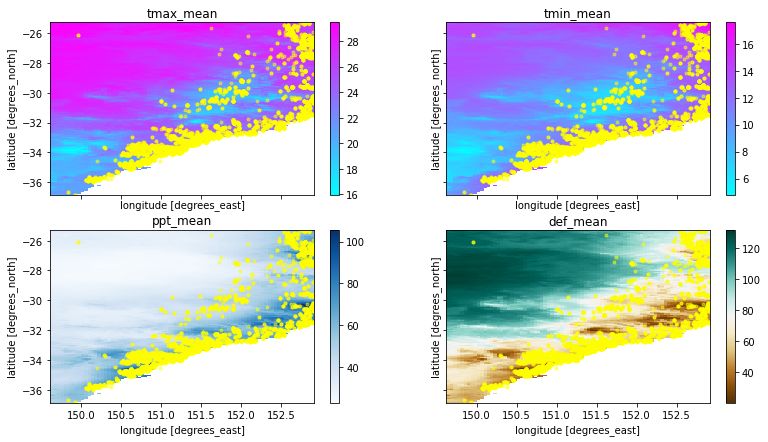

In [15]:
#The spatial distribution of the four variables are displayed below.
nrow = 2
ncol = 2
fig, ax = plt.subplots(nrow, ncol, figsize=(13, 7), sharex=True, sharey=True)

bands = weather_data.band.values
filt = all_frog_data.occurrenceStatus == 1
cmaps = ["cool", "cool", "Blues", "BrBG"]

for i in range(len(bands)):
    xr.plot.imshow(weather_data[i], 'x', 'y', cmap=cmaps[i], ax=ax[i//ncol, i%ncol]) 
    ax[i//ncol, i%ncol].set_title(bands[i])
    ax[i//ncol, i%ncol].scatter(all_frog_data[filt].decimalLongitude, all_frog_data[filt].decimalLatitude,
                                color = 'yellow', marker='.', alpha=0.5, label=target_species if i==0 else '')

fig.suptitle("Spatial distribution of Terraclimate variables", fontsize=20)
fig.legend(loc=(0.85, 0.933))

In [16]:
def join_frogs(frogs, data):
    """Collects the data for each frog location and joins it onto the frog data 

    Arguments:
    frogs -- dataframe containing the response variable along with ["decimalLongitude", "decimalLatitude", "key"]
    data -- xarray dataarray of features, indexed with geocoordinates
    """

    return frogs.merge(
        (
            data
            .rename('data')
            .sel(
                x=xr.DataArray(all_frog_data.decimalLongitude, dims="key", coords={"key": all_frog_data.key}), 
                y=xr.DataArray(all_frog_data.decimalLatitude, dims="key", coords={"key": all_frog_data.key}),
                method="nearest"
            )
            .to_dataframe()
            .assign(val = lambda x: x.iloc[:, -1])
            [['val']]
            .reset_index()
            .drop_duplicates()
            .pivot(index="key", columns="band", values="val")
            .reset_index()
        ),
        on = ['key'],
        how = 'inner'
    )
    
model_data = join_frogs(all_frog_data, weather_data)
model_data.head()

,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species,occurrenceStatus,key,def_mean,pet_mean,ppt_mean,q_mean,srad_mean,tmax_mean,tmin_mean,vap_mean,vpd_mean,ws_mean
0,1944370584,2018-04-18 19:05:00,Australia,Australia,New South Wales,-33.693144,151.320884,Litoria Fallax,1,0,39.500000,117.583333,83.708333,5.125000,201.833333,23.437501,13.662501,1.459167,0.694167,4.125000
1,2423011701,2019-08-28 09:24:00,Australia,Australia,New South Wales,-33.925746,151.164082,Litoria Fallax,1,1,50.083333,119.750000,73.708333,3.666667,198.875000,23.433334,13.662501,1.427083,0.742917,4.162500
2,2236299662,2018-02-13 23:02:00,Australia,Australia,New South Wales,-31.732415,152.088515,Litoria Fallax,1,2,47.375000,115.166667,70.666667,3.583333,208.625000,23.254168,10.941669,1.234167,0.786250,2.887500
3,3031765405,2018-02-20 15:20:00,Australia,Australia,Queensland,-27.400618,152.800944,Litoria Fallax,1,3,56.291667,122.541667,70.166667,4.500000,212.500000,25.150001,13.312502,1.515833,0.845417,3.429167
4,2446280067,2018-01-22 00:00:00,Australia,Australia,New South Wales,-33.086880,151.420570,Litoria Fallax,1,4,56.583333,117.958333,64.375000,3.208333,204.916667,23.662502,12.962502,1.427917,0.714583,3.770833


The frequency distribution of each variable is displayed below. There is some skewness present in a few variables, so you might want to address this when training your own model. Depending on the type of model you decide to train, some of the variables might require normalisation, standardisation, or transformation. 

### Feature Engineering

Text(0.5, 0.98, 'Frequency distribution of TerraClimate variables')

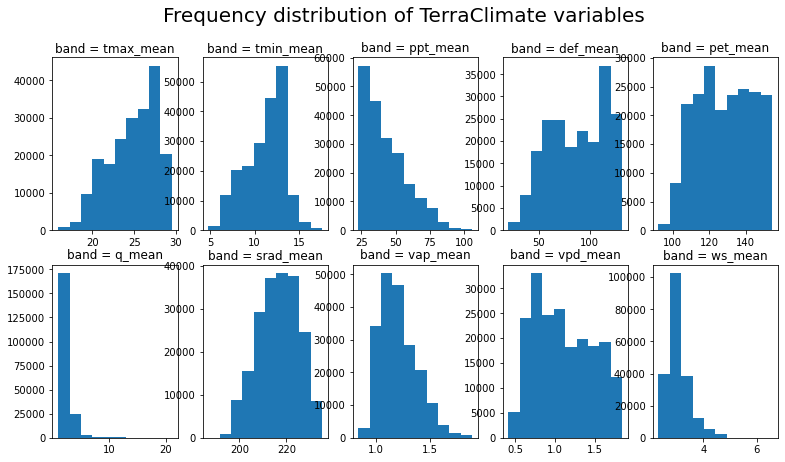

In [18]:
nrow = 2
ncol = 5
fig, ax = plt.subplots(nrow, ncol, figsize=(13, 7))

bands = weather_data.band.values

for i in range(len(bands)):
    xr.plot.hist(weather_data[i], ax=ax[i//ncol, i%ncol])

fig.suptitle("Frequency distribution of TerraClimate variables",  fontsize=20)

### Joining Pretictors to the Response Variable

Now that we have read in our predictor variables, we need to join them onto the response variable of frogs. To do this, we loop through the frog occurrence data and assign each frog occurrence the closest predictor pixel value from each of the predictor variables based on the geo-coordinates. The `sel` method of the xarray dataarray comes in handy here.

In [19]:
def join_frogs(frogs, data):
    """Collects the data for each frog location and joins it onto the frog data 

    Arguments:
    frogs -- dataframe containing the response variable along with ["decimalLongitude", "decimalLatitude", "key"]
    data -- xarray dataarray of features, indexed with geocoordinates
    """

    return frogs.merge(
        (
            data
            .rename('data')
            .sel(
                x=xr.DataArray(all_frog_data.decimalLongitude, dims="key", coords={"key": all_frog_data.key}), 
                y=xr.DataArray(all_frog_data.decimalLatitude, dims="key", coords={"key": all_frog_data.key}),
                method="nearest"
            )
            .to_dataframe()
            .assign(val = lambda x: x.iloc[:, -1])
            [['val']]
            .reset_index()
            .drop_duplicates()
            .pivot(index="key", columns="band", values="val")
            .reset_index()
        ),
        on = ['key'],
        how = 'inner'
    )
    
model_data = join_frogs(all_frog_data, weather_data)
model_data.head()

,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species,occurrenceStatus,key,def_mean,pet_mean,ppt_mean,q_mean,srad_mean,tmax_mean,tmin_mean,vap_mean,vpd_mean,ws_mean
0,1944370584,2018-04-18 19:05:00,Australia,Australia,New South Wales,-33.693144,151.320884,Litoria Fallax,1,0,39.500000,117.583333,83.708333,5.125000,201.833333,23.437501,13.662501,1.459167,0.694167,4.125000
1,2423011701,2019-08-28 09:24:00,Australia,Australia,New South Wales,-33.925746,151.164082,Litoria Fallax,1,1,50.083333,119.750000,73.708333,3.666667,198.875000,23.433334,13.662501,1.427083,0.742917,4.162500
2,2236299662,2018-02-13 23:02:00,Australia,Australia,New South Wales,-31.732415,152.088515,Litoria Fallax,1,2,47.375000,115.166667,70.666667,3.583333,208.625000,23.254168,10.941669,1.234167,0.786250,2.887500
3,3031765405,2018-02-20 15:20:00,Australia,Australia,Queensland,-27.400618,152.800944,Litoria Fallax,1,3,56.291667,122.541667,70.166667,4.500000,212.500000,25.150001,13.312502,1.515833,0.845417,3.429167
4,2446280067,2018-01-22 00:00:00,Australia,Australia,New South Wales,-33.086880,151.420570,Litoria Fallax,1,4,56.583333,117.958333,64.375000,3.208333,204.916667,23.662502,12.962502,1.427917,0.714583,3.770833


In [20]:
#average known values and insert into missing values
#features=['tmax_mean', 'tmin_mean', 'ppt_mean', 'soil_mean', 'def_mean', 'pdsi_mean', 'pet_mean', 'q_mean', 
          #'srad_mean', 'vap_mean', 'vpd_mean', 'ws_mean']

ppt_mean_mean = np.nanmean(model_data.ppt_mean)
#soil_mean_mean = np.nanmean(model_data.soil_mean)
tmax_mean_mean = np.nanmean(model_data.tmax_mean)
tmin_mean_mean = np.nanmean(model_data.tmin_mean)
def_mean_mean = np.nanmean(model_data.def_mean) 
#pdsi_mean_mean = np.nanmean(model_data.pdsi_mean)
pet_mean_mean = np.nanmean(model_data.pet_mean)
q_mean_mean = np.nanmean(model_data.q_mean)
srad_mean_mean = np.nanmean(model_data.srad_mean)
vap_mean_mean = np.nanmean(model_data.vap_mean)
vpd_mean_mean = np.nanmean(model_data.vpd_mean)
ws_mean_mean = np.nanmean(model_data.ws_mean)

model_data.ppt_mean.fillna(ppt_mean_mean, inplace=True)
#model_data.soil_mean.fillna(soil_mean_mean, inplace=True)
model_data.tmax_mean.fillna(tmax_mean_mean, inplace=True)
model_data.tmin_mean.fillna(tmin_mean_mean, inplace=True)
model_data.def_mean.fillna(def_mean_mean, inplace=True)
#model_data.pdsi_mean.fillna(pdsi_mean_mean, inplace=True)
model_data.pet_mean.fillna(pet_mean_mean, inplace=True)
model_data.q_mean.fillna(q_mean_mean, inplace=True)
model_data.srad_mean.fillna(srad_mean_mean, inplace=True)
model_data.vap_mean.fillna(vap_mean_mean, inplace=True)
model_data.vpd_mean.fillna(vpd_mean_mean, inplace=True)
model_data.ws_mean.fillna(ws_mean_mean, inplace=True)

model_data.head()

,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species,occurrenceStatus,key,def_mean,pet_mean,ppt_mean,q_mean,srad_mean,tmax_mean,tmin_mean,vap_mean,vpd_mean,ws_mean
0,1944370584,2018-04-18 19:05:00,Australia,Australia,New South Wales,-33.693144,151.320884,Litoria Fallax,1,0,39.500000,117.583333,83.708333,5.125000,201.833333,23.437501,13.662501,1.459167,0.694167,4.125000
1,2423011701,2019-08-28 09:24:00,Australia,Australia,New South Wales,-33.925746,151.164082,Litoria Fallax,1,1,50.083333,119.750000,73.708333,3.666667,198.875000,23.433334,13.662501,1.427083,0.742917,4.162500
2,2236299662,2018-02-13 23:02:00,Australia,Australia,New South Wales,-31.732415,152.088515,Litoria Fallax,1,2,47.375000,115.166667,70.666667,3.583333,208.625000,23.254168,10.941669,1.234167,0.786250,2.887500
3,3031765405,2018-02-20 15:20:00,Australia,Australia,Queensland,-27.400618,152.800944,Litoria Fallax,1,3,56.291667,122.541667,70.166667,4.500000,212.500000,25.150001,13.312502,1.515833,0.845417,3.429167
4,2446280067,2018-01-22 00:00:00,Australia,Australia,New South Wales,-33.086880,151.420570,Litoria Fallax,1,4,56.583333,117.958333,64.375000,3.208333,204.916667,23.662502,12.962502,1.427917,0.714583,3.770833


In [21]:
print("missing values:", model_data.isna().sum().sum()) #check how many missing data

missing values: 0


## Model Diagnostics 

In [22]:
#assign response and predictors
x = (model_data.drop(['gbifID', 'eventDate', 'decimalLatitude', 'decimalLongitude', 'species',
       'country', 'continent', 'stateProvince', 'occurrenceStatus', 'key'], 1))
y = model_data.occurrenceStatus.astype(int)

In [23]:
#linear regression model
lin_model = LinearRegression().fit(x, y)
lin_model

LinearRegression()

In [24]:
#r_sq = model.score(x, y)
#print(f"coefficient of determination: {r_sq}")
#print(f"intercept: {model.intercept_}")
#print(f"coefficients: {model.coef_}")

In [25]:
## OLS linear Regression
import statsmodels.api as sm
x_constant = sm.add_constant(x)
est = sm.OLS(y, x_constant)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:       occurrenceStatus   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     458.8
Date:                Thu, 02 Jun 2022   Prob (F-statistic):               0.00
Time:                        11:11:39   Log-Likelihood:                -16758.
No. Observations:               26914   AIC:                         3.354e+04
Df Residuals:                   26903   BIC:                         3.363e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.3806      0.333     -7.154      0.0

### Comment
Based on a basic multiple linear regression OLS analysis, with a constant applied, there are 3 out of 12 predictors that have a high p-value, which means that they are NOT significant when all predictors are looked at together against the response of OccurrenceStatus. This suggests that 'soil_mean', 'srad_mean', and 'tmin_mean' are not significant in predicting frog occurrences. The OLS model flags the AIC as being high, which protentially suggests strong multicollinearity or other issues. 

In [26]:
#Linear Regression with reduced Predictors 
x1 = (x.drop(['srad_mean', 'tmin_mean'], 1))

In [27]:
#ols
x1_constant = sm.add_constant(x1)
reduced_est = sm.OLS(y, x1_constant)
reduced_est2 = reduced_est.fit()
print(reduced_est2.summary())

                            OLS Regression Results                            
Dep. Variable:       occurrenceStatus   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     572.2
Date:                Thu, 02 Jun 2022   Prob (F-statistic):               0.00
Time:                        11:11:47   Log-Likelihood:                -16763.
No. Observations:               26914   AIC:                         3.354e+04
Df Residuals:                   26905   BIC:                         3.362e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.5758      0.095    -16.567      0.0

### Comment
All p-values are significant for the reduced set of 9 predictors: def_mean, pdsi_mean, pet_mean, ppt_mean, q_mean, tmax_mean, vap_mean, vpd_mean, ws_mean. However, there is still a case of multicollinearity or other issues present.

In [28]:
import pandas as pd 
import numpy as np 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score 
from featurewiz import featurewiz
np.random.seed(1)

Imported version = 0.1.55.
from featurewiz import FeatureWiz
wiz = FeatureWiz(verbose=1)
X_train_selected = wiz.fit_transform(X_train, y_train)
X_test_selected = wiz.transform(X_test)
wiz.features  ### provides a list of selected features ###
                                


In [29]:
#standardize features using full model
X_scaled =  StandardScaler().fit_transform(x) 

#split data
X_train, X_valid, y_train, y_valid = train_test_split(X_scaled,y,test_size = 0.2,stratify=y, random_state=1)

## Fit Random Forest model
classifier = RandomForestClassifier()
classifier.fit(X_train,y_train)

#Make a prediction on the validation set and then check model performance.
# make prediction 
preds = classifier.predict(X_valid) 
# check performance
accuracy_score(preds,y_valid) 

0.7677874791008731

In [30]:
#standardize features using reduced model
X_scaled =  StandardScaler().fit_transform(x1) 

#split data
X_train, X_valid, y_train, y_valid = train_test_split(X_scaled,y,test_size = 0.2,stratify=y, random_state=1)

## Fit Random Forest model
classifier = RandomForestClassifier()
classifier.fit(X_train,y_train)

#Make a prediction on the validation set and then check model performance.
# make prediction 
preds = classifier.predict(X_valid) 
# check performance
accuracy_score(preds,y_valid) 

0.7676017090841538

In [31]:
reduced_data = (model_data.drop(['gbifID', 'eventDate', 'decimalLatitude', 'decimalLongitude', 'species',
       'country', 'continent', 'stateProvince', 'key'], 1))
reduced_data.head()

,occurrenceStatus,def_mean,pet_mean,ppt_mean,q_mean,srad_mean,tmax_mean,tmin_mean,vap_mean,vpd_mean,ws_mean
0,1,39.500000,117.583333,83.708333,5.125000,201.833333,23.437501,13.662501,1.459167,0.694167,4.125000
1,1,50.083333,119.750000,73.708333,3.666667,198.875000,23.433334,13.662501,1.427083,0.742917,4.162500
2,1,47.375000,115.166667,70.666667,3.583333,208.625000,23.254168,10.941669,1.234167,0.786250,2.887500
3,1,56.291667,122.541667,70.166667,4.500000,212.500000,25.150001,13.312502,1.515833,0.845417,3.429167
4,1,56.583333,117.958333,64.375000,3.208333,204.916667,23.662502,12.962502,1.427917,0.714583,3.770833


############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
**INFO: featurewiz can now read feather formatted files. Loading train data...
    Shape of your Data Set loaded: (26914, 11)
    Loaded train data. Shape = (26914, 11)
No test data filename given...
Classifying features using a random sample of 10000 rows from dataset...
#### Single_Label Binary_Classification problem ####
    loading a random sample of 10000 rows into pandas for EDA
#######################################################################################
################

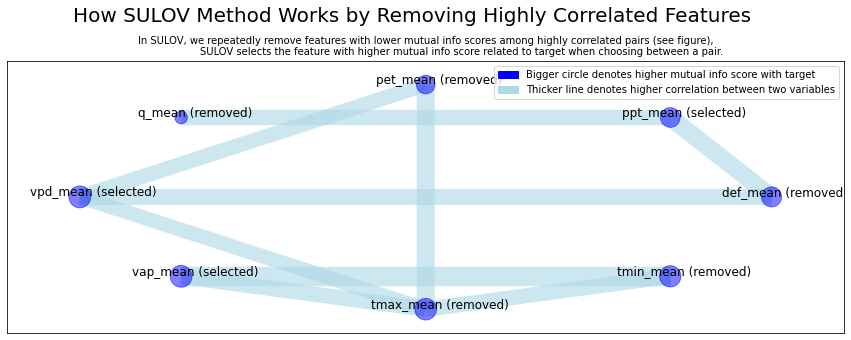

Time taken for SULOV method = 1 seconds
    Adding 0 categorical variables to reduced numeric variables  of 5
Final list of selected vars after SULOV = 5
Readying dataset for Recursive XGBoost by converting all features to numeric...
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
Train and Test loaded into Dask dataframes successfully after feature_engg completed
Current number of predictors = 5 
    XGBoost version: 1.5.1
Number of booster rounds = 100
        using 5 variables...
            Time taken for regular XGBoost feature selection = 0 seconds
        using 3 variables...
            Time taken for regular XGBoost feature selection = 1 seconds


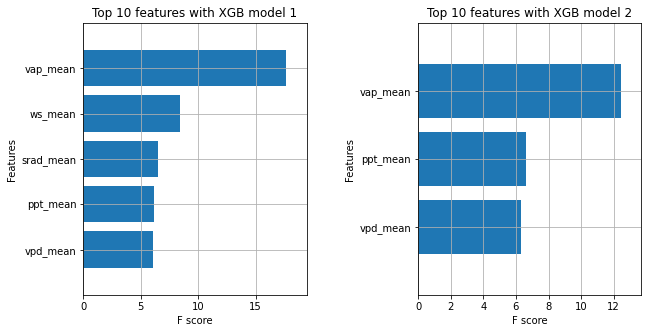

            Total time taken for XGBoost feature selection = 1 seconds
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Selected 5 important features:
['vap_mean', 'ws_mean', 'srad_mean', 'ppt_mean', 'vpd_mean']

    Time taken for feature selection = 2 seconds
Returning 2 dataframes: dataname and test_data with 5 important features.


In [32]:
## Feature Selection
# automatic feature selection by using featurewiz package
target = 'occurrenceStatus'
 
features, train = featurewiz(reduced_data, target, corr_limit=0.7, verbose=2, sep=",",
header=0,test_data="", feature_engg="", category_encoders="")

In [34]:
#split data into feature and target
X_new = reduced_data.drop(['occurrenceStatus','def_mean', 'pet_mean','q_mean', 'tmax_mean', 'tmin_mean'],axis=1)
X_new

y = reduced_data.occurrenceStatus.values

In [35]:
X_new.head()

,ppt_mean,srad_mean,vap_mean,vpd_mean,ws_mean
0,83.708333,201.833333,1.459167,0.694167,4.125000
1,73.708333,198.875000,1.427083,0.742917,4.162500
2,70.666667,208.625000,1.234167,0.786250,2.887500
3,70.166667,212.500000,1.515833,0.845417,3.429167
4,64.375000,204.916667,1.427917,0.714583,3.770833


### XGBoost

In [36]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## XGBoost
classifier = XGBClassifier()
classifier.fit(X_new, y)

#predictions with xgboost
predictions = classifier.predict(X_new)

# check performance
accuracy_score(predictions,y) 

0.7821951400757969

### QDA

In [37]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

classifier = QuadraticDiscriminantAnalysis()
classifier.fit(X_new, y)

predictions = classifier.predict(X_new)
# check performance
accuracy_score(predictions,y) 

0.6496618860072825

### Logistic Regression

In [38]:
full_model = LogisticRegression()

# Fit model
full_model.fit(X_new, y)

log_reg = sm.Logit(y, x).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.590292
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                26914
Model:                          Logit   Df Residuals:                    26904
Method:                           MLE   Df Model:                            9
Date:                Thu, 02 Jun 2022   Pseudo R-squ.:                  0.1178
Time:                        11:14:02   Log-Likelihood:                -15887.
converged:                       True   LL-Null:                       -18009.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
def_mean      -0.7019      0.053    -13.162      0.000      -0.806      -0.597
pet_mean       0.9350      0.

### Random Forest

In [39]:
np.random.seed(1)

# create and train classifier 
classifier = RandomForestClassifier()
classifier.fit(X_new,y)

# make prediction 
predictions = classifier.predict(X_new) 

# check performance
accuracy_score(predictions,y) 

0.7838299769636621

#### Predict Entire Region

In [40]:
def predict_frogs(predictor_image, model):
    """Returns a (1, n, m) xarray where each pixel value corresponds to the probability of a frog occurrence.
    
    Takes in the multi-band image outputted by the `create_predictor_image` function as well as the
    trained model and returns the predictions for each pixel value. Firstly, the $x$ and $y$ indexes
    in the predictor image are stacked into one multi-index $z=(x, y)$ to produce an $k\times n$
    array, which is the format required to feed into our logistic regression model. Then, the array
    is fed into the model, returning the model's predictions for the frog likelihood at each pixel. 
    The predicted probabilities are then indexed by the same multi-index $z$ as before, which allows 
    the array to be unstacked and returned as a one-band image, ready for plotting.

    Arguments:
    predictor_image -- (K, n, m) xarray, where K is the number of predictor variables.
    model -- sklearn model with K predictor variables.
    """
    # Stack up pixels so they are in the appropriate format for the model
    predictor_image = predictor_image.stack(z=("y", "x")).transpose()
    # Reorder variables to be in same order as model
    predictor_image = predictor_image.sel(band=model.feature_names_in_)
    # Location of null values so that we can skip them (prediction model will break if nulls are present)
    null_pixels = (np.sum(predictor_image.isnull(), axis=-1) > 0)
    # Empty probabilities array
    probabilities = np.zeros((len(null_pixels), 2))
    # Calculate probability for each non-null pixel point
    probabilities[~null_pixels] = model.predict_proba(
        predictor_image[~null_pixels]
    )
    # Set null pixels to a probability of null
    probabilities[null_pixels] = np.array([np.nan, np.nan])
    # Just take probability of frog (class=1)
    probabilities = probabilities[:,1]
    # Add the coordinates to the probabilities, saving them in an xarray
    resultant_image = xr.DataArray(
        data=probabilities,
        dims=['z'],
        coords=dict(
            z=predictor_image.z
        )
    )
    # Unstack the image
    resultant_image = resultant_image.unstack()
    return resultant_image

# Calculate probability for each pixel point 
resultant_image = predict_frogs(weather_data, classifier)

### In-Sample Evaluation


In [41]:
print(f"F1 Score: {np.mean(f1_score(y, predictions)).round(2)}")
print(f"Accuracy: {np.mean(accuracy_score(y, predictions)).round(2)}")

F1 Score: 0.73
Accuracy: 0.78


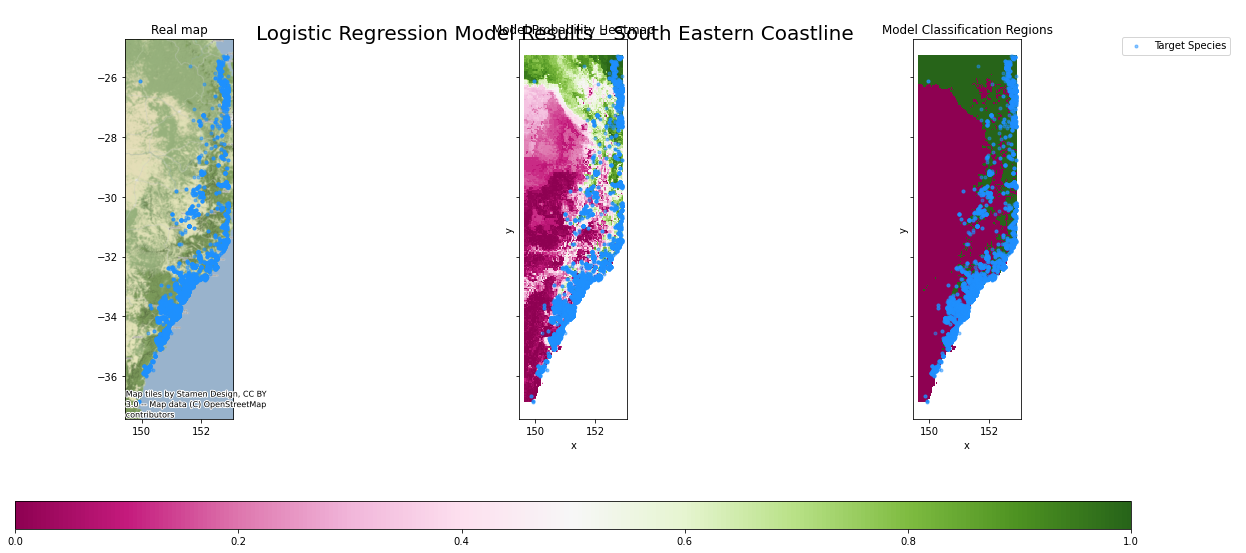

In [42]:
def plot_heatmap(resultant_image, all_frog_data, title, crs = {'init':'epsg:4326'}):
    """Plots a real map, probability heatmap, and model classification regions for the probability image from our model.

    Arguments:
    resultant_image -- (1, n, m) xarray of probabilities output from the model
    all_frog_data -- Dataframe of frog occurrences, indicated with a 1 in the occurrenceStatus column. 
                 Must contain ["occurrenceStatus", "decimalLongitude", "decimalLatitude"]
    title -- string that will be displayed as the figure title
    crs -- coordinate reference system for plotting the real map. Defaults to EPSG:4326.
    """
    fig, ax = plt.subplots(1, 3, figsize = (20, 10), sharex=True, sharey=True)
    extent = [resultant_image.x.min(),resultant_image.x.max(),resultant_image.y.min(),resultant_image.y.max()]
    cmap = 'PiYG'

    # Plot real map
    ax[0].scatter(x=[extent[0], extent[1]], y=[extent[2], extent[3]], alpha=0)
    cx.add_basemap(ax[0], crs=crs)
    ax[0].set_title('Real map')
    
    # Plot heatmap from model
    heatmap = resultant_image.plot.imshow(
        x='x', y='y', ax=ax[1], cmap=cmap, vmin=0, vmax=1, interpolation='none', add_colorbar=False
    )
    ax[1].set_aspect('equal')
    ax[1].set_title('Model Probability Heatmap')

    # Plot binary classification from model
    regions = xr.where(resultant_image.isnull(), np.nan, resultant_image>0.5).plot.imshow(
            x='x', y='y', ax=ax[2], cmap=cmap, vmin=0, vmax=1, interpolation='none', add_colorbar=False
    )
    ax[2].set_aspect('equal')
    ax[2].set_title('Model Classification Regions')

    # Plot real frogs
    for i, axis in enumerate(ax):
        filt = all_frog_data.occurrenceStatus == 1
        axis.scatter(
            all_frog_data[filt].decimalLongitude, all_frog_data[filt].decimalLatitude, 
            color = 'dodgerblue', marker='.', alpha=0.5, label='Target Species' if i==0 else ''
        )

    fig.colorbar(heatmap, ax=ax, location = 'bottom', aspect=40)
    fig.legend(loc = (0.9, 0.9))
    fig.suptitle(title, x=0.5, y=0.9, fontsize=20)
    
plot_heatmap(resultant_image, all_frog_data, f"Logistic Regression Model Results - {region_name}")

In [44]:
# Load in test coordinates
test_file = pd.read_csv('challenge_1_submission_template.csv')

# Read in test regions
test_1_regions = []
with open('challenge_1_test_regions.txt', 'r') as file: 
    for i, line in enumerate(file):
        if i > 0:
            test_1_regions.append(eval("("+line+")"))
            
# Load in regions and save as list of dictionaries.
test_regions = [{'title':i, 'bbox':bbox} for i, bbox in enumerate(test_1_regions)]


Loading data
<xarray.DataArray 'stack-5bd1953fc2583efd81565eabb4d6fc79' (variable: 10, time: 24, y: 24, x: 24)>
array([[[[ 28.90000153,  29.09999847,  28.90000153, ...,  28.09999847,
           27.        ,  26.30000305],
         [ 29.        ,  28.90000153,  28.80000305, ...,  27.40000153,
           25.59999847,  24.80000305],
         [ 29.        ,  28.90000153,  28.90000153, ...,  26.40000153,
           25.        ,  24.59999847],
         ...,
         [ 24.90000153,  25.20000458,  25.5       , ...,  26.40000153,
           26.5       ,  26.5       ],
         [ 24.80000305,  25.        ,  24.90000153, ...,  26.30000305,
           26.30000305,  26.5       ],
         [         nan,          nan,  24.5       , ...,  26.30000305,
           26.40000153,  26.30000305]],

        [[ 27.5       ,  27.80000305,  27.70000458, ...,  27.09999847,
           26.30000305,  25.80000305],
         [ 27.5       ,  27.5       ,  27.5       , ...,  26.70000458,
           25.09999847,  24.099

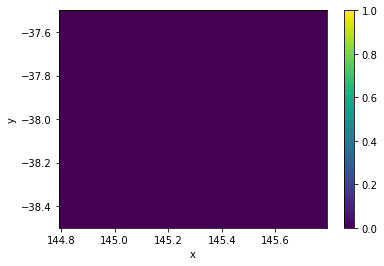

Loading data
<xarray.DataArray 'stack-6ad994229856f1c764017c98003d6077' (variable: 10, time: 24, y: 24, x: 24)>
array([[[[ 32.40000153,  32.30000305,  33.        , ...,  31.90000153,
           31.30000305,  31.        ],
         [ 32.90000153,  32.        ,  32.30000305, ...,  31.70000458,
           31.        ,  30.80000305],
         [ 32.        ,  31.09999847,  31.80000305, ...,  31.5       ,
           30.70000458,  30.59999847],
         ...,
         [ 31.        ,  30.90000153,  30.80000305, ...,          nan,
                   nan,          nan],
         [ 31.09999847,  31.09999847,  31.09999847, ...,          nan,
                   nan,          nan],
         [ 31.20000458,  31.09999847,  31.09999847, ...,          nan,
                   nan,          nan]],

        [[ 30.09999847,  29.90000153,  30.59999847, ...,  30.        ,
           29.5       ,  29.30000305],
         [ 30.59999847,  29.80000305,  30.09999847, ...,  29.90000153,
           29.30000305,  29.200

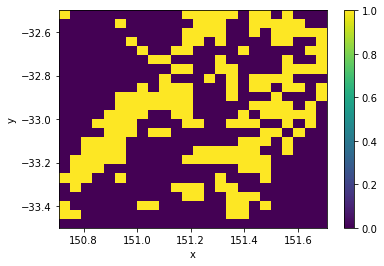

Loading data
<xarray.DataArray 'stack-a499d356903bb9d7e93d1ee0b973ce69' (variable: 10, time: 24, y: 24, x: 24)>
array([[[[ 31.70000458,  32.59999847,  32.70000458, ...,          nan,
                   nan,          nan],
         [ 32.80000305,  32.59999847,  32.20000458, ...,          nan,
                   nan,          nan],
         [ 32.59999847,  32.59999847,  31.80000305, ...,  30.80000305,
                   nan,          nan],
         ...,
         [ 32.09999847,  32.        ,  31.59999847, ...,  29.70000458,
           29.70000458,  29.5       ],
         [ 31.80000305,  31.80000305,  31.5       , ...,  29.80000305,
           29.70000458,          nan],
         [ 31.80000305,  31.30000305,  31.30000305, ...,  29.70000458,
           29.59999847,          nan]],

        [[ 29.59999847,  30.30000305,  30.40000153, ...,          nan,
                   nan,          nan],
         [ 30.5       ,  30.20000458,  30.        , ...,          nan,
                   nan,        

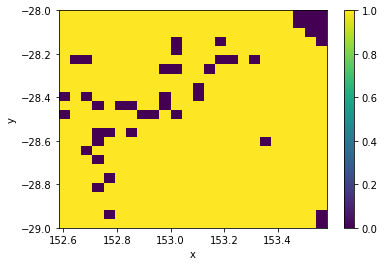

Loading data
<xarray.DataArray 'stack-ae37a0d77b8c7326316ce0a2deccc0e5' (variable: 10, time: 24, y: 24, x: 24)>
array([[[[3.19000015e+01, 3.14000015e+01, 3.10000000e+01, ...,
                     nan,            nan,            nan],
         [3.17000046e+01, 3.10999985e+01, 3.09000015e+01, ...,
                     nan,            nan, 3.22000046e+01],
         [3.19000015e+01, 3.14000015e+01, 3.10000000e+01, ...,
                     nan,            nan,            nan],
         ...,
         [3.10999985e+01, 3.09000015e+01, 3.09000015e+01, ...,
          3.15999985e+01, 3.17000046e+01, 3.19000015e+01],
         [3.10999985e+01, 3.10000000e+01, 3.10000000e+01, ...,
          3.15999985e+01, 3.19000015e+01, 3.17000046e+01],
         [3.12000046e+01, 3.10999985e+01, 3.12000046e+01, ...,
          3.17000046e+01, 3.18000031e+01, 3.15999985e+01]],

        [[3.10000000e+01, 3.05000000e+01, 3.02000046e+01, ...,
                     nan,            nan,            nan],
         [3.070000

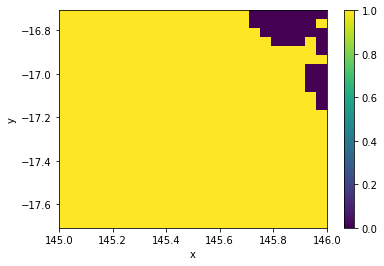

Loading data
<xarray.DataArray 'stack-c6f209446baaff97372c7c824546d4f3' (variable: 10, time: 24, y: 24, x: 24)>
array([[[[30.40000153, 30.5       , 30.70000458, ..., 33.70000458,
          34.09999847, 34.40000153],
         [30.09999847, 30.30000305, 30.5       , ..., 33.90000153,
          34.30000305, 34.30000305],
         [30.20000458, 30.40000153, 30.90000153, ..., 33.80000305,
          34.30000305, 34.30000305],
         ...,
         [29.30000305, 29.5       , 29.80000305, ..., 31.59999847,
          31.90000153, 32.30000305],
         [        nan, 29.5       , 29.80000305, ..., 31.40000153,
          31.5       , 31.5       ],
         [29.30000305, 29.59999847, 29.90000153, ..., 31.09999847,
          31.09999847, 31.20000458]],

        [[29.90000153, 30.        , 30.        , ..., 32.40000153,
          32.90000153, 33.20000458],
         [29.70000458, 29.90000153, 30.        , ..., 32.59999847,
          33.09999847, 33.        ],
         [29.80000305, 30.        , 30.4

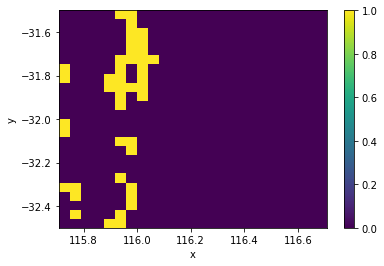

In [45]:
# Obtain predictor data for each region and get predictor image
for region in test_regions:
    region['coords'] = filter_bbox(test_file[['id', 'decimalLongitude', 'decimalLatitude']], region['bbox'])
    region['predictors'] = get_terraclimate(region['bbox'], tc_metrics, time_slice=time_slice, assets=assets, features=features)
    region['result'] = predict_frogs(region['predictors'], classifier) > 0.5
    
    region['result'].plot.imshow(x='x', y='y', vmin=0, vmax=1)
    plt.show()

In [46]:
predictions = pd.DataFrame()

for region in test_regions:
    preds = (
        region['result'].rename('occurrenceStatus')
        .sel(
            x=xr.DataArray(region['coords'].decimalLongitude, dims="id", coords={"id": region['coords'].id}), 
            y=xr.DataArray(region['coords'].decimalLatitude, dims="id", coords={"id": region['coords'].id}),
            method="nearest"
        )
        .to_dataframe()
        .reset_index()
        .rename(columns={'x':'decimalLongitude', 'y':'decimalLatitude'})
    )
    predictions = predictions.append(preds)
            
submission = (    
    predictions.merge(
        test_file, 
        on=['decimalLongitude', 'decimalLatitude'], 
        how='left', suffixes = ('', '_'))
    [test_file.columns]
    .fillna(0)
    .astype({col:'int' for col in test_file.columns[3::]})
)


In [47]:
display(submission)

# Save to output folder
submission.to_csv('challenge_1_RF_Final_Submission.csv', index=None)

,id,decimalLatitude,decimalLongitude,occurrenceStatus
0,0,-37.937500,145.187500,0
1,1,-37.770833,144.979167,0
2,2,-37.979167,145.354167,0
3,3,-37.604167,145.020833,0
4,4,-38.479167,145.645833,0
...,...,...,...,...
4046,4046,-31.895833,116.145833,0
4047,4047,-32.395833,115.770833,0
4048,4048,-32.145833,115.854167,0
4049,4049,-31.812500,116.229167,0
